In [1]:
import glob
import pandas as pd
import tqdm
#from pyfasta import Fasta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import seaborn as sns
import numpy as np

In [2]:
import pickle

In [3]:
import os
repo_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
dataframe_paths = os.sep.join([repo_dir,'data_lists'])

## Gathering the data
    1. Gathering GSE numebers
    2. GSE->SRR mapping
    3. Get GSE objects and meta-data
    4. Read Cedar files 
    5. Construct data Matrix

In [4]:
def getGSEDataframe(srrnames):
    accession_df = pd.read_csv(os.sep.join([dataframe_paths,'GSE_GSM_SRR_SIZE.tsv']),usecols=['GSE','GSM','SRA'])
    return accession_df.loc[accession_df.SRA.isin(srrnames)]

In [5]:
def initializeDataLab(listFile):
    gse_data_file1 = listFile
    
    gse_data = pd.read_table(gse_data_file1, header=None,\
                              names=['GSE','SRR','mate1','mate2'])
    gse_data.drop_duplicates(inplace=True)
    return gse_data

In [6]:
def getSRR4Exp(filename):
    srrnames = pd.read_table(filename, header = None, names=['SRR'])
    return srrnames.SRR.values

In [18]:
def prepareDFBact(seq2taxFile, nameList):    
    taxamap = seq2taxFile
    seqtaxamap = pd.read_table(taxamap,names=['organism','txid'])
    name_dict = {}
    
    with open(nameList) as fp:
        names = fp.readlines()
        for line in names:
            name_dict["|".join(line.strip().split("|")[:4]) + "|"] = line.strip().split("|")[4].split(",")[0].strip()
    seqtaxamap.loc[:,'names'] = seqtaxamap.organism.map(name_dict.get)
    txid_name_tuples = zip(seqtaxamap.names.values,seqtaxamap.txid)
    
    duplicated_txid = defaultdict(list)
    for name,txid in txid_name_tuples:
        duplicated_txid[txid].append(name)
            
    plasmid_removed = {}
    for tid, names in duplicated_txid.items():
        if len(names) > 1:
            for name in names:
                if not 'plasmid' in name:
                    plasmid_removed[tid] = name
            if not tid in plasmid_removed:
                plasmid_removed[tid] = names[-1]
        else:
            plasmid_removed[tid] = names[0]
    
    return plasmid_removed

def prepareDFVirus(seq2taxFile, nameList):    
    taxamap = seq2taxFile
    seqtaxamap = pd.read_table(taxamap,names=['organism','txid'])
    name_dict = {}
    
    with open(nameList) as fp:
        names = fp.readlines()
        for line in names:
            name_dict[line.strip().split(' ')[0]] = ' '.join(line.strip().split(' ')[1:]).split(',')[0]
    
    seqtaxamap.loc[:,'names'] = seqtaxamap.organism.map(name_dict.get)
    txid_name_tuples = zip(seqtaxamap.names.values,seqtaxamap.txid)
    
    duplicated_txid = defaultdict(list)
    for name,txid in txid_name_tuples:
        duplicated_txid[txid].append(name)
    
    plasmid_removed = {}
    for tid, names in duplicated_txid.items():
        if len(names) > 1:
            for name in names:
                #print('{}:{}'.format(tid,name))
                #if name != None:
                if not 'plasmid' in name:
                    plasmid_removed[tid] = name
            if not tid in plasmid_removed:
                plasmid_removed[tid] = names[-1]
        else:
            plasmid_removed[tid] = names[0]
    
    return plasmid_removed

def readCedarfiles(cedarfiles, plasmid_removed):
    
    cedar_df = pd.DataFrame(index=plasmid_removed.keys())
    for ced1 in tqdm.tqdm(cedarfiles):
        samplename = ced1.split("/")[-1].split(".")[0]
        df_ced1 = pd.read_table(ced1,usecols=['taxaId','count'])
        df_ced1.columns = ['taxaId',samplename]
        df_ced1.set_index(['taxaId'],inplace=True)
        cedar_df = cedar_df.join(df_ced1)
    cedar_df = cedar_df.fillna(0.0)
    cedar_df['names']=cedar_df.index.map(plasmid_removed.get)
    cedar_df['names']=cedar_df['names'].str[:30]
    #print(cedar_df['names'])
    tax_df = pd.Series(cedar_df.names.values,index=cedar_df.index).to_dict()
    cedar_df.set_index(['names'],inplace=True)
    
    return  tax_df, cedar_df

In [19]:
plasmid_removed = prepareDFVirus("/mnt/scratch3/meta_genome/combined_contamenation/seqid2taxid.map",
                                "/mnt/scratch3/meta_genome/combined_contamenation/names.list")

## Experiment Specific

In [70]:
#srrnames = getSRR4Exp(exp_dir+"/SRA.list")

# compare mm and uniq

In [63]:
exp_dir = "/mnt/scratch4/meta_genome/viral_contamination/cedar_output_MAY26"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
old_uniq_cedar_dict , old_uniq_cedar_df = readCedarfiles(cedarfiles,plasmid_removed)

100%|██████████| 130/130 [00:01<00:00, 100.70it/s]


In [64]:
exp_dir = "/mnt/scratch4/meta_genome/viral_contamination/cedar_output_jun3"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
old_mm_cedar_dict , old_mm_cedar_df = readCedarfiles(cedarfiles,plasmid_removed)

100%|██████████| 130/130 [00:01<00:00, 118.98it/s]


In [20]:
exp_dir = "/mnt/scratch3/meta_genome/combined_contamenation/jun23_cedar"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
uniq_cedar_dict , uniq_cedar_df = readCedarfiles(cedarfiles,plasmid_removed)

100%|██████████| 157/157 [00:02<00:00, 75.45it/s] 


In [22]:
exp_dir = "/mnt/scratch3/meta_genome/combined_contamenation/jun23_cedar/mm"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
mm_cedar_dict , mm_cedar_df = readCedarfiles(cedarfiles,plasmid_removed)

100%|██████████| 157/157 [00:01<00:00, 96.97it/s] 


In [46]:
exp_dir = "/mnt/scratch3/meta_genome/combined_contamenation/jul2_head1m_cedar/"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
head_uniq_cedar_dict , head_uniq_cedar_df = readCedarfiles(cedarfiles,plasmid_removed)

100%|██████████| 157/157 [00:01<00:00, 124.52it/s]


In [47]:
exp_dir = "/mnt/scratch3/meta_genome/combined_contamenation/jul2_head1m_cedar/mm"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
head_mm_cedar_dict , head_mm_cedar_df = readCedarfiles(cedarfiles,plasmid_removed)

100%|██████████| 157/157 [00:01<00:00, 128.59it/s]


# Old Pipeline vs New Pipeline (points of difference)

In [76]:
print(' Previous old results from discordant reads:')
print('uniq: {}'.format(np.sum(old_uniq_cedar_df.sum(axis=1)>0)))
print('multimapped: {}'.format(np.sum(old_mm_cedar_df.sum(axis=1)>0)))
print(' The Full Hisat2 + Head Version')
print('uniq: {}'.format(np.sum(head_uniq_cedar_df.sum(axis=1)>0)))
print('multimapped: {}'.format(np.sum(head_mm_cedar_df.sum(axis=1)>0)))
print(' The one with interrupting Hisat2')
print('uniq: {}'.format(np.sum(uniq_cedar_df.sum(axis=1)>0)))
print('multimapped: {}'.format(np.sum(mm_cedar_df.sum(axis=1)>0)))

 Previous old results from discordant reads:
uniq: 1122
multimapped: 1193
 The Full Hisat2 + Head Version
uniq: 1237
multimapped: 1302
 The one with interrupting Hisat2
uniq: 1237
multimapped: 1300


In [55]:
uniq_mm = pd.concat([uniq_cedar_df.sum(axis=1),(head_uniq_cedar_df.sum(axis=1))], axis=1).reset_index()
uniq_mm.columns=['names', 'new', 'old']
uniq_mm[uniq_mm['old'] != uniq_mm['new']]

,names,new,old
4,Human adenovirus A,17.0,18.0
94,Arthrobacter sp. FB24,1346.0,1347.0
196,Bradyrhizobium sp. ORS 278 chr,7796.0,7795.0
242,Nitratiruptor sp. SB155-2,79.0,78.0
344,Bordetella petrii DSM 12804 ch,520.0,518.0
352,Thermoanaerobacter sp. X514 ch,510.0,511.0
361,Mycobacterium abscessus chromo,761.0,760.0
363,Methylobacterium sp. 4-46 chro,5048.0,5051.0
451,Candidatus Phytoplasma mali ch,389.0,391.0
465,Candidatus Phytoplasma austral,147.0,146.0


In [74]:
gse_gsm_srr = getGSEDataframe(cedar_df.columns)

In [75]:
gse_gsm_srr.drop_duplicates(['SRA'],inplace=True)

In [76]:
cedar_df_transpose = cedar_df.T

## Analysing Clusters
    1. Clustering with respect to species
    2. Clustering with respect to samples

In [20]:
annot_df = pd.read_table(os.sep.join([dataframe_paths,'Annotation_Frame.tsv']), index_col=0)

In [21]:
annot_df_sub = annot_df.loc[annot_df.SRA.isin(gse_gsm_srr.SRA)]

In [22]:
annot_df_sub.drop_duplicates(inplace=True)

/home/fatemeh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
annot_df_sub = annot_df_sub.merge(gse_gsm_srr,on='SRA',how='left')

In [24]:
cedar_df_transpose = cedar_df_transpose.reindex(annot_df_sub.SRA)

In [25]:
def getMostAbundant(k=2):
    df = cedar_df_transpose
    most_abundant = pd.DataFrame({n: df.T[column].nlargest(k).index.tolist() for n, column in enumerate(df.T)}).T
    return most_abundant

In [27]:
cedar_dict_df.reset_index(level=0, inplace=True)

In [70]:
cedar_dict_df.columns = ['Taxa', 'Name']

## Start plotting

In [29]:
from bokeh.plotting import figure, show
from bokeh.models import CategoricalColorMapper, ColumnDataSource

from bokeh.io import output_notebook
from sklearn.manifold import TSNE

In [56]:
#import umap

In [57]:
#embedding = TSNE(n_components=2).fit_transform(np.log(cedar_df_transpose.values+1))

In [74]:
#embedding_umap = umap.UMAP().fit_transform(np.log(cedar_df_transpose.values+1))

In [59]:
def getArbitColor(N):
    x = np.random.random(size=N) * 100
    y = np.random.random(size=N) * 100
    radii = np.random.random(size=N) * 1.5
    colors = [
        "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
    ]
    return colors

def drawBokehPlotSamples(vector,df,info):
    from bokeh.palettes import viridis
    from bokeh.palettes import Dark2,Colorblind,grey
    from bokeh.models import ColumnDataSource, HoverTool, CustomJS, OpenURL, TapTool
    from bokeh.models import ZoomInTool, ZoomOutTool,BoxZoomTool,PanTool,ResetTool

    output_notebook()
    #targets = [str(d) for d in set(srr_labels.platform_name.values)]

    #targets = [str(d) for d in set(srr_labels.GSE.values)]
    targets = [str(d) for d in set(df[info].values)]



    source = ColumnDataSource(dict(
        x = [e[0] for e in vector],
        y = [e[1] for e in vector],
    ))
    source.add(df.city.values,name='city')
    source.add(df.country.values,name='country')
    source.add(df.institute.values,name='institute')
    source.add(df.gene.values,name='gene')
    source.add(df.SRA.values,name='SRA')
    source.add(df.GSE.values ,name='GSE')
    source.add(df.GSM.values ,name='GSM')
    #source.add(df.disease.values.str[:3],name='disease')
    source.add(df.disease.str[:30], name='disease')
    #source.add(df[0].values ,name='bac0')
    #source.add(df[1].values ,name='bac1')



    cmap = CategoricalColorMapper(factors=targets,
                                  palette=viridis(len(targets)))
                                  #palette=getArbitColor(len(targets)))
                                  #palette=grey(2))

    zoomi = ZoomInTool()
    zoomo = ZoomOutTool()

    hover = HoverTool(tooltips=[
        ("SRA", " @SRA"),
        ("GSM", " @GSM"),
        ("GSE", " @GSE"),
        ("Institute", " @institute"),
        ("Disease", " @disease"),
        #("Bacteria0", " @bac0"),
        #("Bacteria1", " @bac1"),
        
    ])

    p = figure(tools=[hover,zoomi,zoomo,BoxZoomTool(),PanTool(),ResetTool(),"tap"],title="tSNE embedding of Bacteria")
    cr = p.circle(x='x',
             y='y',
             #radius = 0.15,
             alpha = 0.7,
             source=source,
             color={"field": info, "transform": cmap},
             legend=info
            )


    urlSRA = "https://www.ebi.ac.uk/ena/data/view/@SRA"
    urlGSE = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=@GSE"
    urlGSM = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=@GSM"
    '''
    code = """
    var indices = cb_data.index['1d'].indices;
    cdata = circle.data;
    console.log('GSE: '+ cdata.GSE[indices[0]]);
    """
    callback = CustomJS(args={'circle': cr.data_source}, code=code)
    p.add_tools(HoverTool(tooltips=None, callback=callback, renderers=[cr]))
    '''
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=urlGSM)

    p.legend.background_fill_alpha = 0.4
    #legend = p.legend()
    p.legend.location = (10, -50)
    p.legend.visible = False
    
    show(p)
    
def drawBokehPlotBac(vector,df,info):
    from bokeh.palettes import viridis
    from bokeh.palettes import Dark2,Colorblind,grey
    from bokeh.models import ColumnDataSource, HoverTool, CustomJS, OpenURL, TapTool
    from bokeh.models import ZoomInTool, ZoomOutTool,BoxZoomTool,PanTool,ResetTool

    output_notebook()
    #targets = [str(d) for d in set(srr_labels.platform_name.values)]

    #targets = [str(d) for d in set(srr_labels.GSE.values)]
    targets = [str(d) for d in set(df.index.values)]



    source = ColumnDataSource(dict(
        x = [e[0] for e in vector],
        y = [e[1] for e in vector],
    ))
    source.add(df.index.values ,name='name')
    
    cmap = CategoricalColorMapper(factors=targets,
    #                              palette=viridis(len(targets)))
                                  palette=getArbitColor(len(targets)))
                                  #palette=grey(2))

    zoomi = ZoomInTool()
    zoomo = ZoomOutTool()

    
    hover = HoverTool(tooltips=[
        ("Name", " @name"),
        
        
    ])
    

    p = figure(tools=[hover,zoomi,zoomo,BoxZoomTool(),PanTool(),ResetTool(),"tap"],title="tSNE embedding of Bacteria")
    cr = p.circle(x='x',
             y='y',
             #radius = 0.15,
             source=source,
             color={"field": "name", "transform": cmap},
             #legend=info
            )


    urlSRA = "https://www.ebi.ac.uk/ena/data/view/@SRA"
    urlGSE = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=@GSE"
    urlGSM = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=@GSM"
    '''
    code = """
    var indices = cb_data.index['1d'].indices;
    cdata = circle.data;
    console.log('GSE: '+ cdata.GSE[indices[0]]);
    """
    callback = CustomJS(args={'circle': cr.data_source}, code=code)
    p.add_tools(HoverTool(tooltips=None, callback=callback, renderers=[cr]))
    '''
    #taptool = p.select(type=TapTool)
    #taptool.callback = OpenURL(url=urlGSE)

    #p.legend.background_fill_alpha = 0.4
    #legend = p.legend()
    #p.legend.location = (10, -50)
    #p.legend.visible = False
    
    show(p)

In [61]:
#drawBokehPlotSamples(embedding_umap,annot_df_sub,'institute')

# mapping count distribution accross references

Text(0,0.5,'# of references with x as the count of mapped reads')

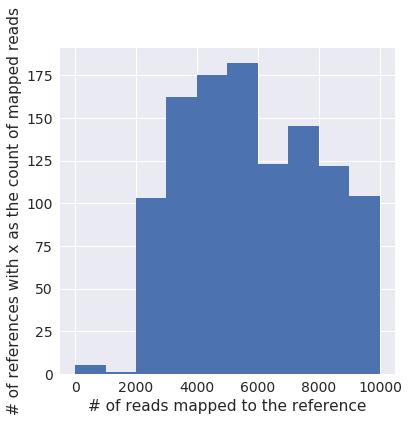

In [86]:
plt.figure(figsize=(6,6))
plt.hist(np.nonzero(old_uniq_cedar_df.sum(axis=1)))
plt.xlabel('# of reads mapped to the reference')
plt.ylabel('# of references with x as the count of mapped reads')

Text(0,0.5,'# of references with x as the count of mapped reads')

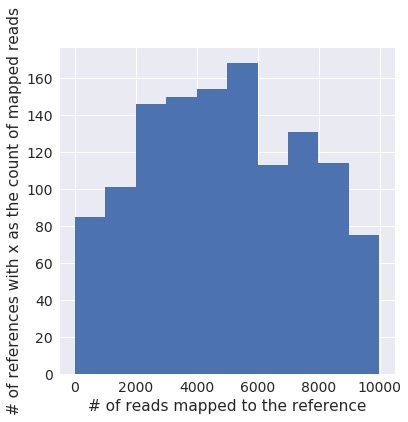

In [87]:
plt.figure(figsize=(6,6))
plt.hist(np.nonzero(uniq_cedar_df.sum(axis=1)))
plt.xlabel('# of reads mapped to the reference')
plt.ylabel('# of references with x as the count of mapped reads')

# Heatmap

In [34]:
def thresholdDataframe(cedar_df,threshold):
    return cedar_df[cedar_df.sum(axis=1) > threshold]

In [35]:
sns.set(font_scale=1.4)
def plotHeatmap(cedar_df, filterthresh):
    cedar_non_zero = thresholdDataframe(cedar_df,filterthresh)
    print("Number of organism which is expressed in any of the samples: {}".format(len(cedar_non_zero)))
    sns.clustermap(np.log(cedar_non_zero+1),metric='correlation', figsize=(15,15), annot_kws={"size": 20})

# Unique mappings --> Old Results including all Discordant reads

experiments: 130
total number of unmapped reads: 5100140.0 
Number of organism which is expressed in any of the samples: 137


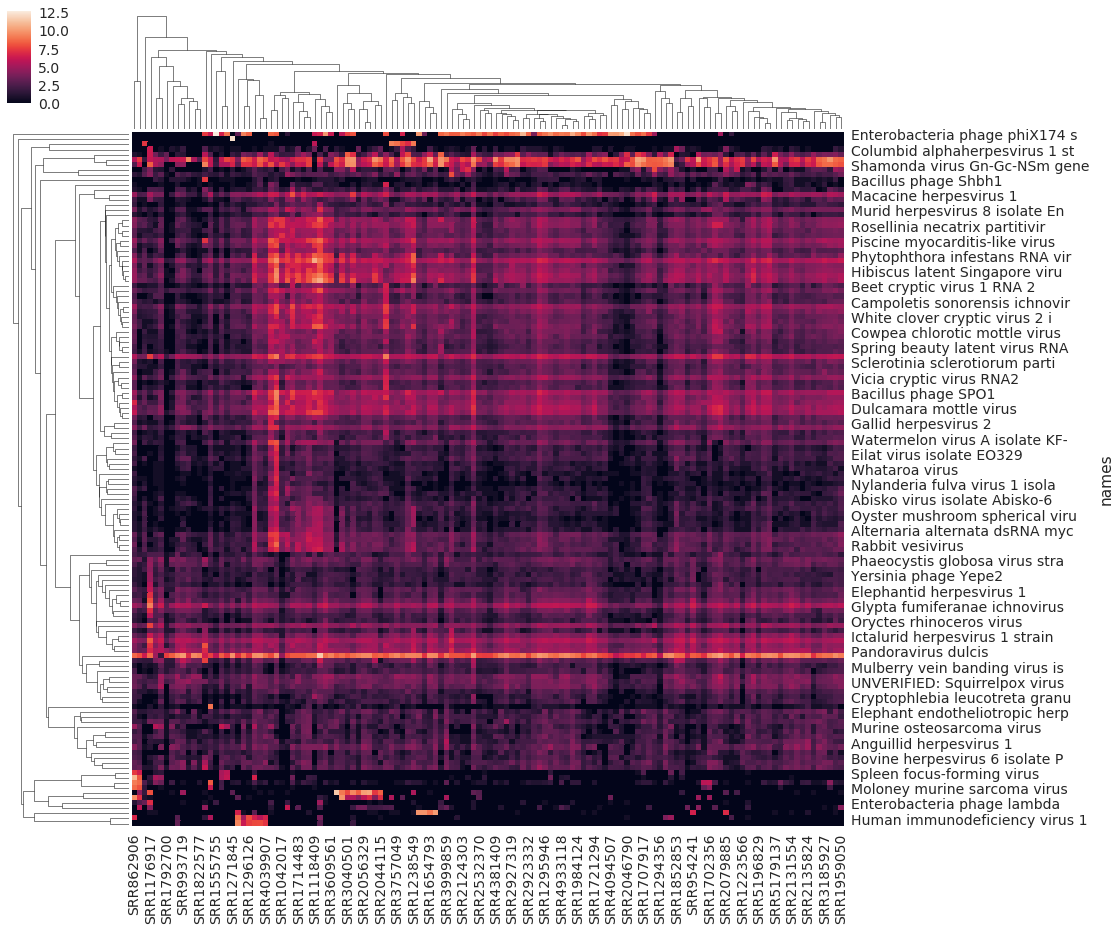

In [73]:
print('experiments: {}'.format(len(old_uniq_cedar_df.columns)))
print('total number of unmapped reads: {} '.format(old_uniq_cedar_df.sum().sum()))
plotHeatmap(old_uniq_cedar_df, 1000.0)

# New Pipeline (Unique Mappings)

experiments: 157
total number of unmapped reads: 10579029.0 
Number of organism which is expressed in any of the samples: 129


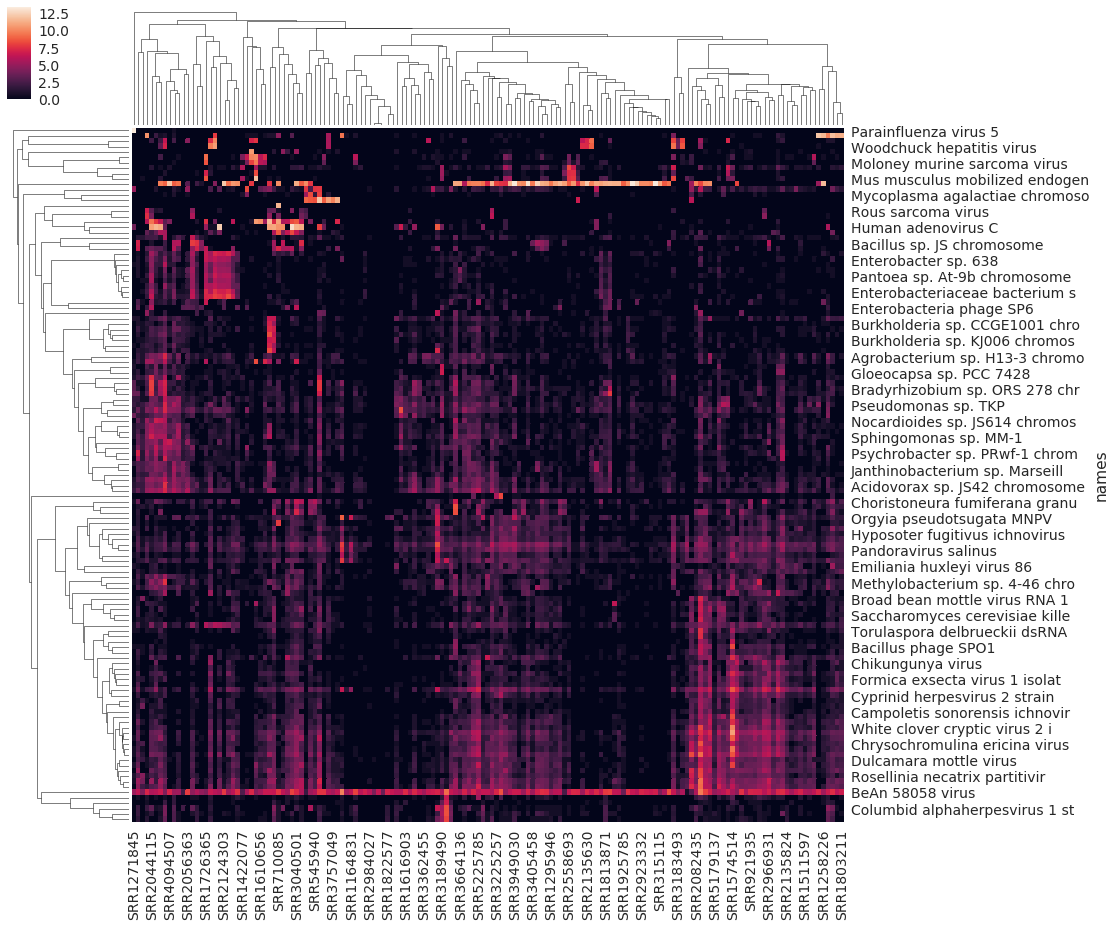

In [72]:
print('experiments: {}'.format(len(uniq_cedar_df.columns)))
print('total number of unmapped reads: {} '.format(uniq_cedar_df.sum().sum()))
plotHeatmap(uniq_cedar_df, 1000.0)

# Multi-mappings --> Old Results including all Discordant reads

Number of organism which is expressed in any of the samples: 139


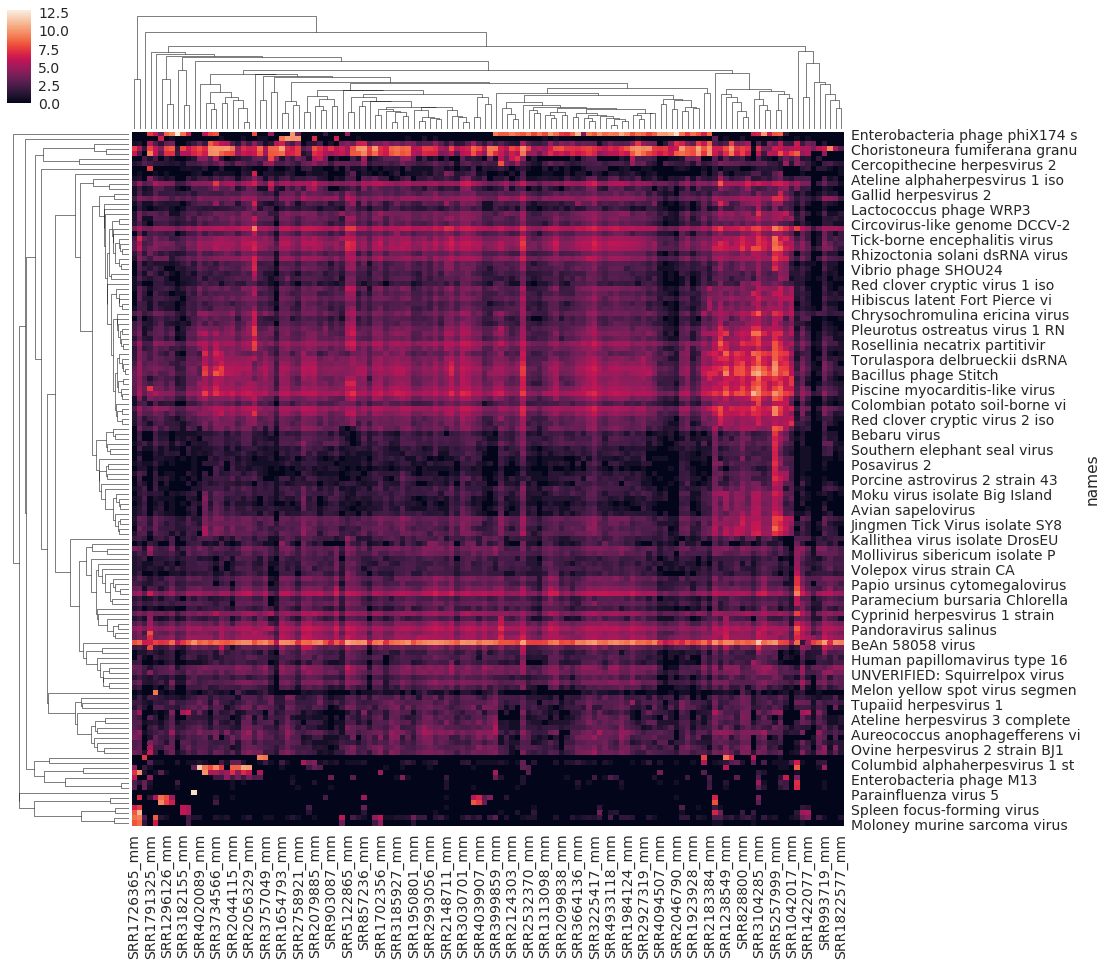

In [41]:
plotHeatmap(old_mm_cedar_df, 1000.0)

# New Pipeline (Multi Mappings)

Number of organism which is expressed in any of the samples: 132


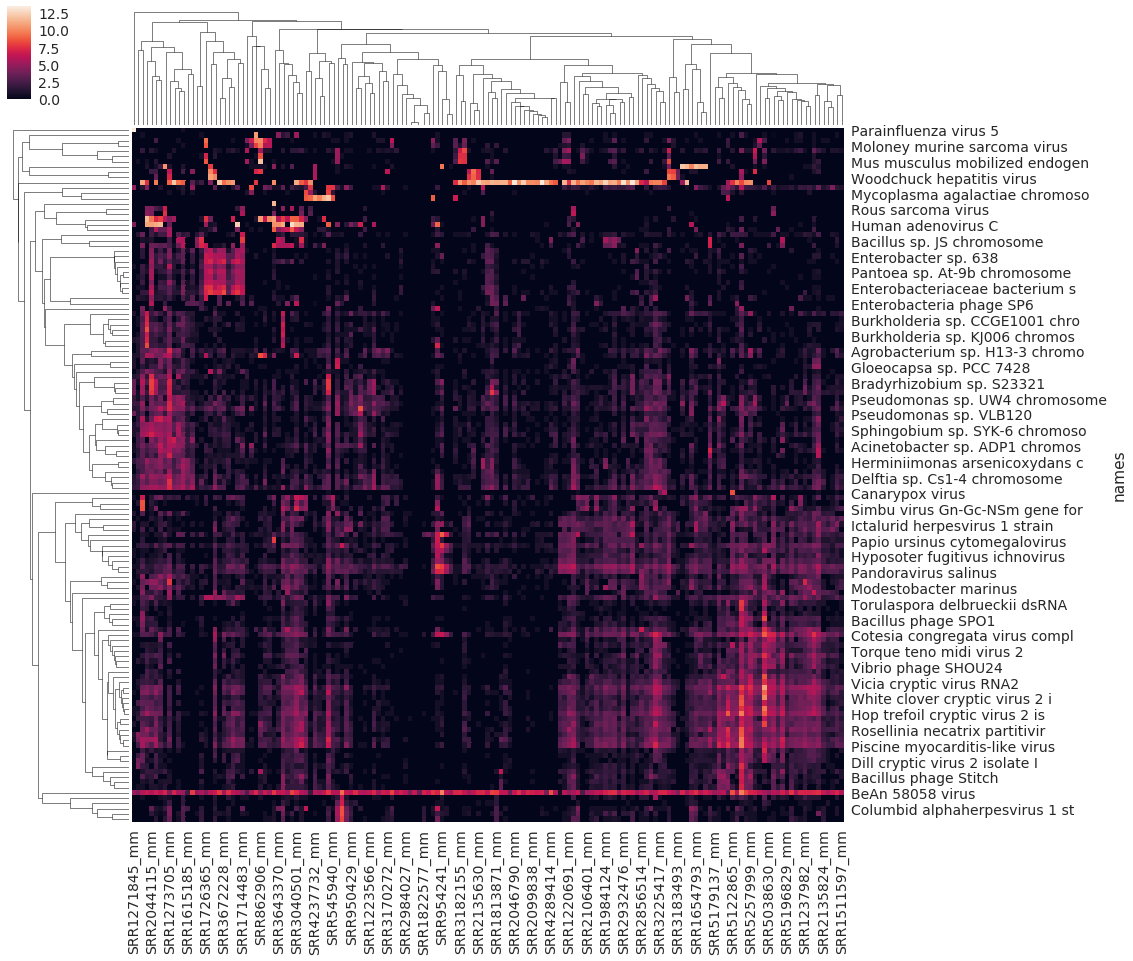

In [37]:
plotHeatmap(mm_cedar_df, 1000.0)

# Yeast

100%|██████████| 28/28 [00:00<00:00, 180.26it/s]


Number of organism which is expressed in any of the samples: 105
['Enterobacteria phage phiX174 s',
 'Ectocarpus siliculosus virus 1',
 'Canarypox virus',
 'Macacine herpesvirus 1',
 'Cotesia congregata virus compl',
 'Lymphocystis disease virus - i',
 'Enterobacteria phage M13',
 'Saimiriine herpesvirus 2 compl',
 'Gallid herpesvirus 2',
 'Saccharomyces cerevisiae virus',
 'Bovine herpesvirus 1',
 'Rabbit fibroma virus',
 'White spot syndrome virus stra',
 'Saccharomyces cerevisiae kille',
 'Tupaiid herpesvirus 1',
 'Helicoverpa armigera NPV',
 'Sorghum chlorotic spot virus R',
 'Broad bean mottle virus RNA 3',
 'Saccharomyces 20S RNA narnavir',
 'Saccharomyces cerevisiae virus',
 'Avian sapelovirus',
 'Oyster mushroom spherical viru',
 'Staphylococcus phage G1',
 'Pleurotus ostreatus virus 1 RN',
 'Human herpesvirus 1 strain 17',
 'Dasheen mosaic virus',
 'Hepatitis C virus genotype 7',
 'Tick-borne encephalitis virus',
 'Dulcamara mottle virus',
 'Vicia cryptic virus RNA2',
 'Campol

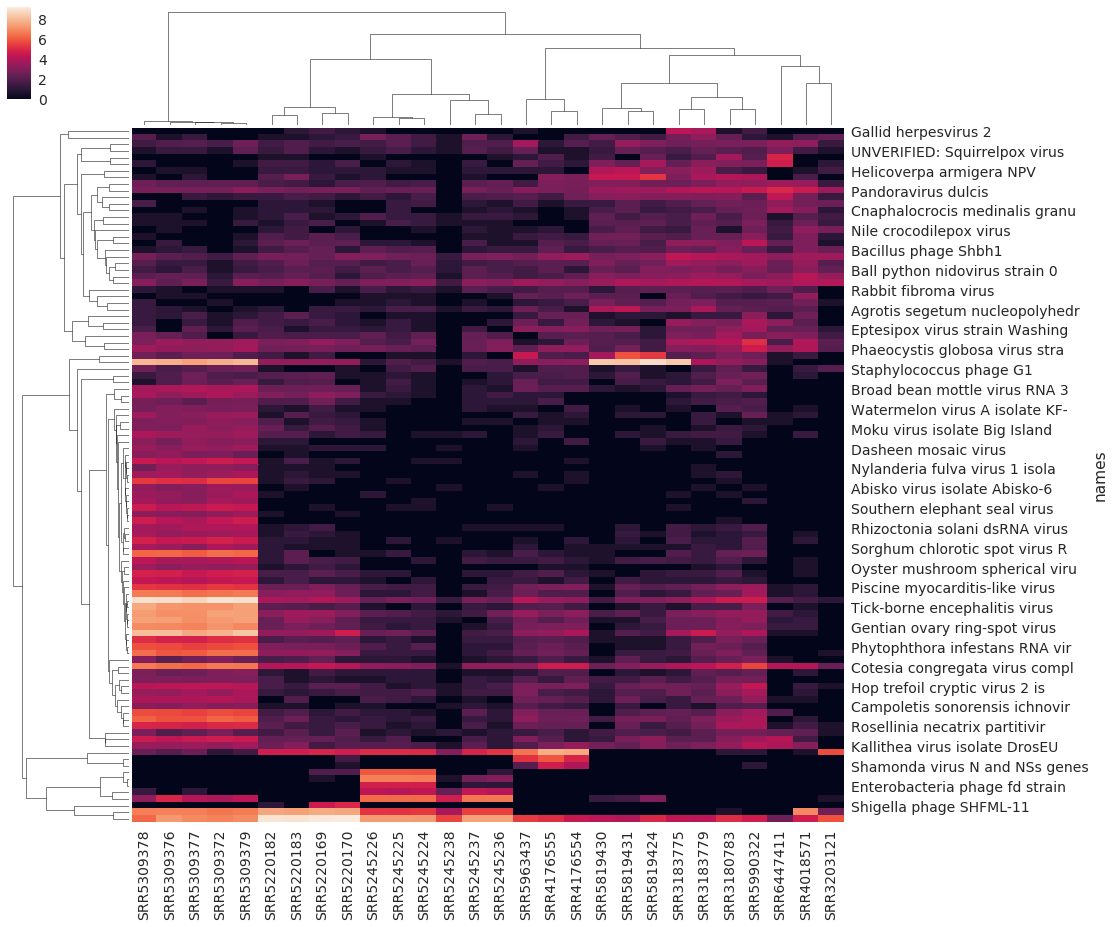

In [221]:
import pprint
exp_dir = "/mnt/scratch4/meta_genome/yeast_cedar/"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
yeast_dict , yeast_df = readCedarfiles(cedarfiles,plasmid_removed)
plotHeatmap(yeast_df, 100.0)
yeast_filtered = thresholdDataframe(yeast_df,100.0)
pprint.pprint(list(yeast_filtered.index))

# Infected

In [209]:
# EBV 
# influenza SRR4436309, SRR4436310, SRR4436326, SRR4436340, SRR4436343, SRR4436360
# rotavirus SRR5069810, SRR5069809
# HIV SRR1106198, SRR1106201

100%|██████████| 20/20 [00:00<00:00, 218.52it/s]


Number of organism which is expressed in any of the samples: 37


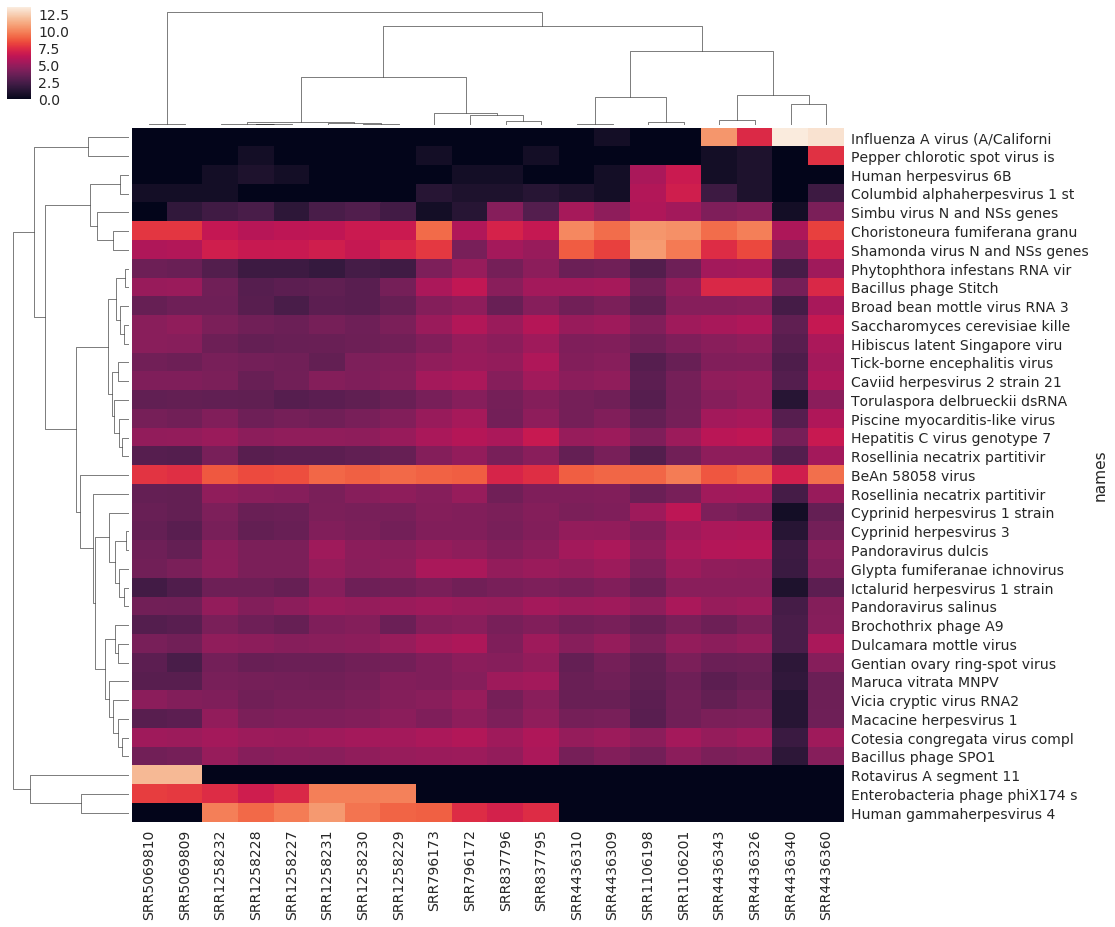

In [218]:
exp_dir = "/mnt/scratch3/meta_genome/jun5_humanInfected20"
cedarfiles = glob.glob(exp_dir+"/*.cedar")
infected_dict , infected_df = readCedarfiles(cedarfiles,plasmid_removed)
plotHeatmap(infected_df, 1000.0)

Number of organism which is expressed more than 10K of the samples: 137


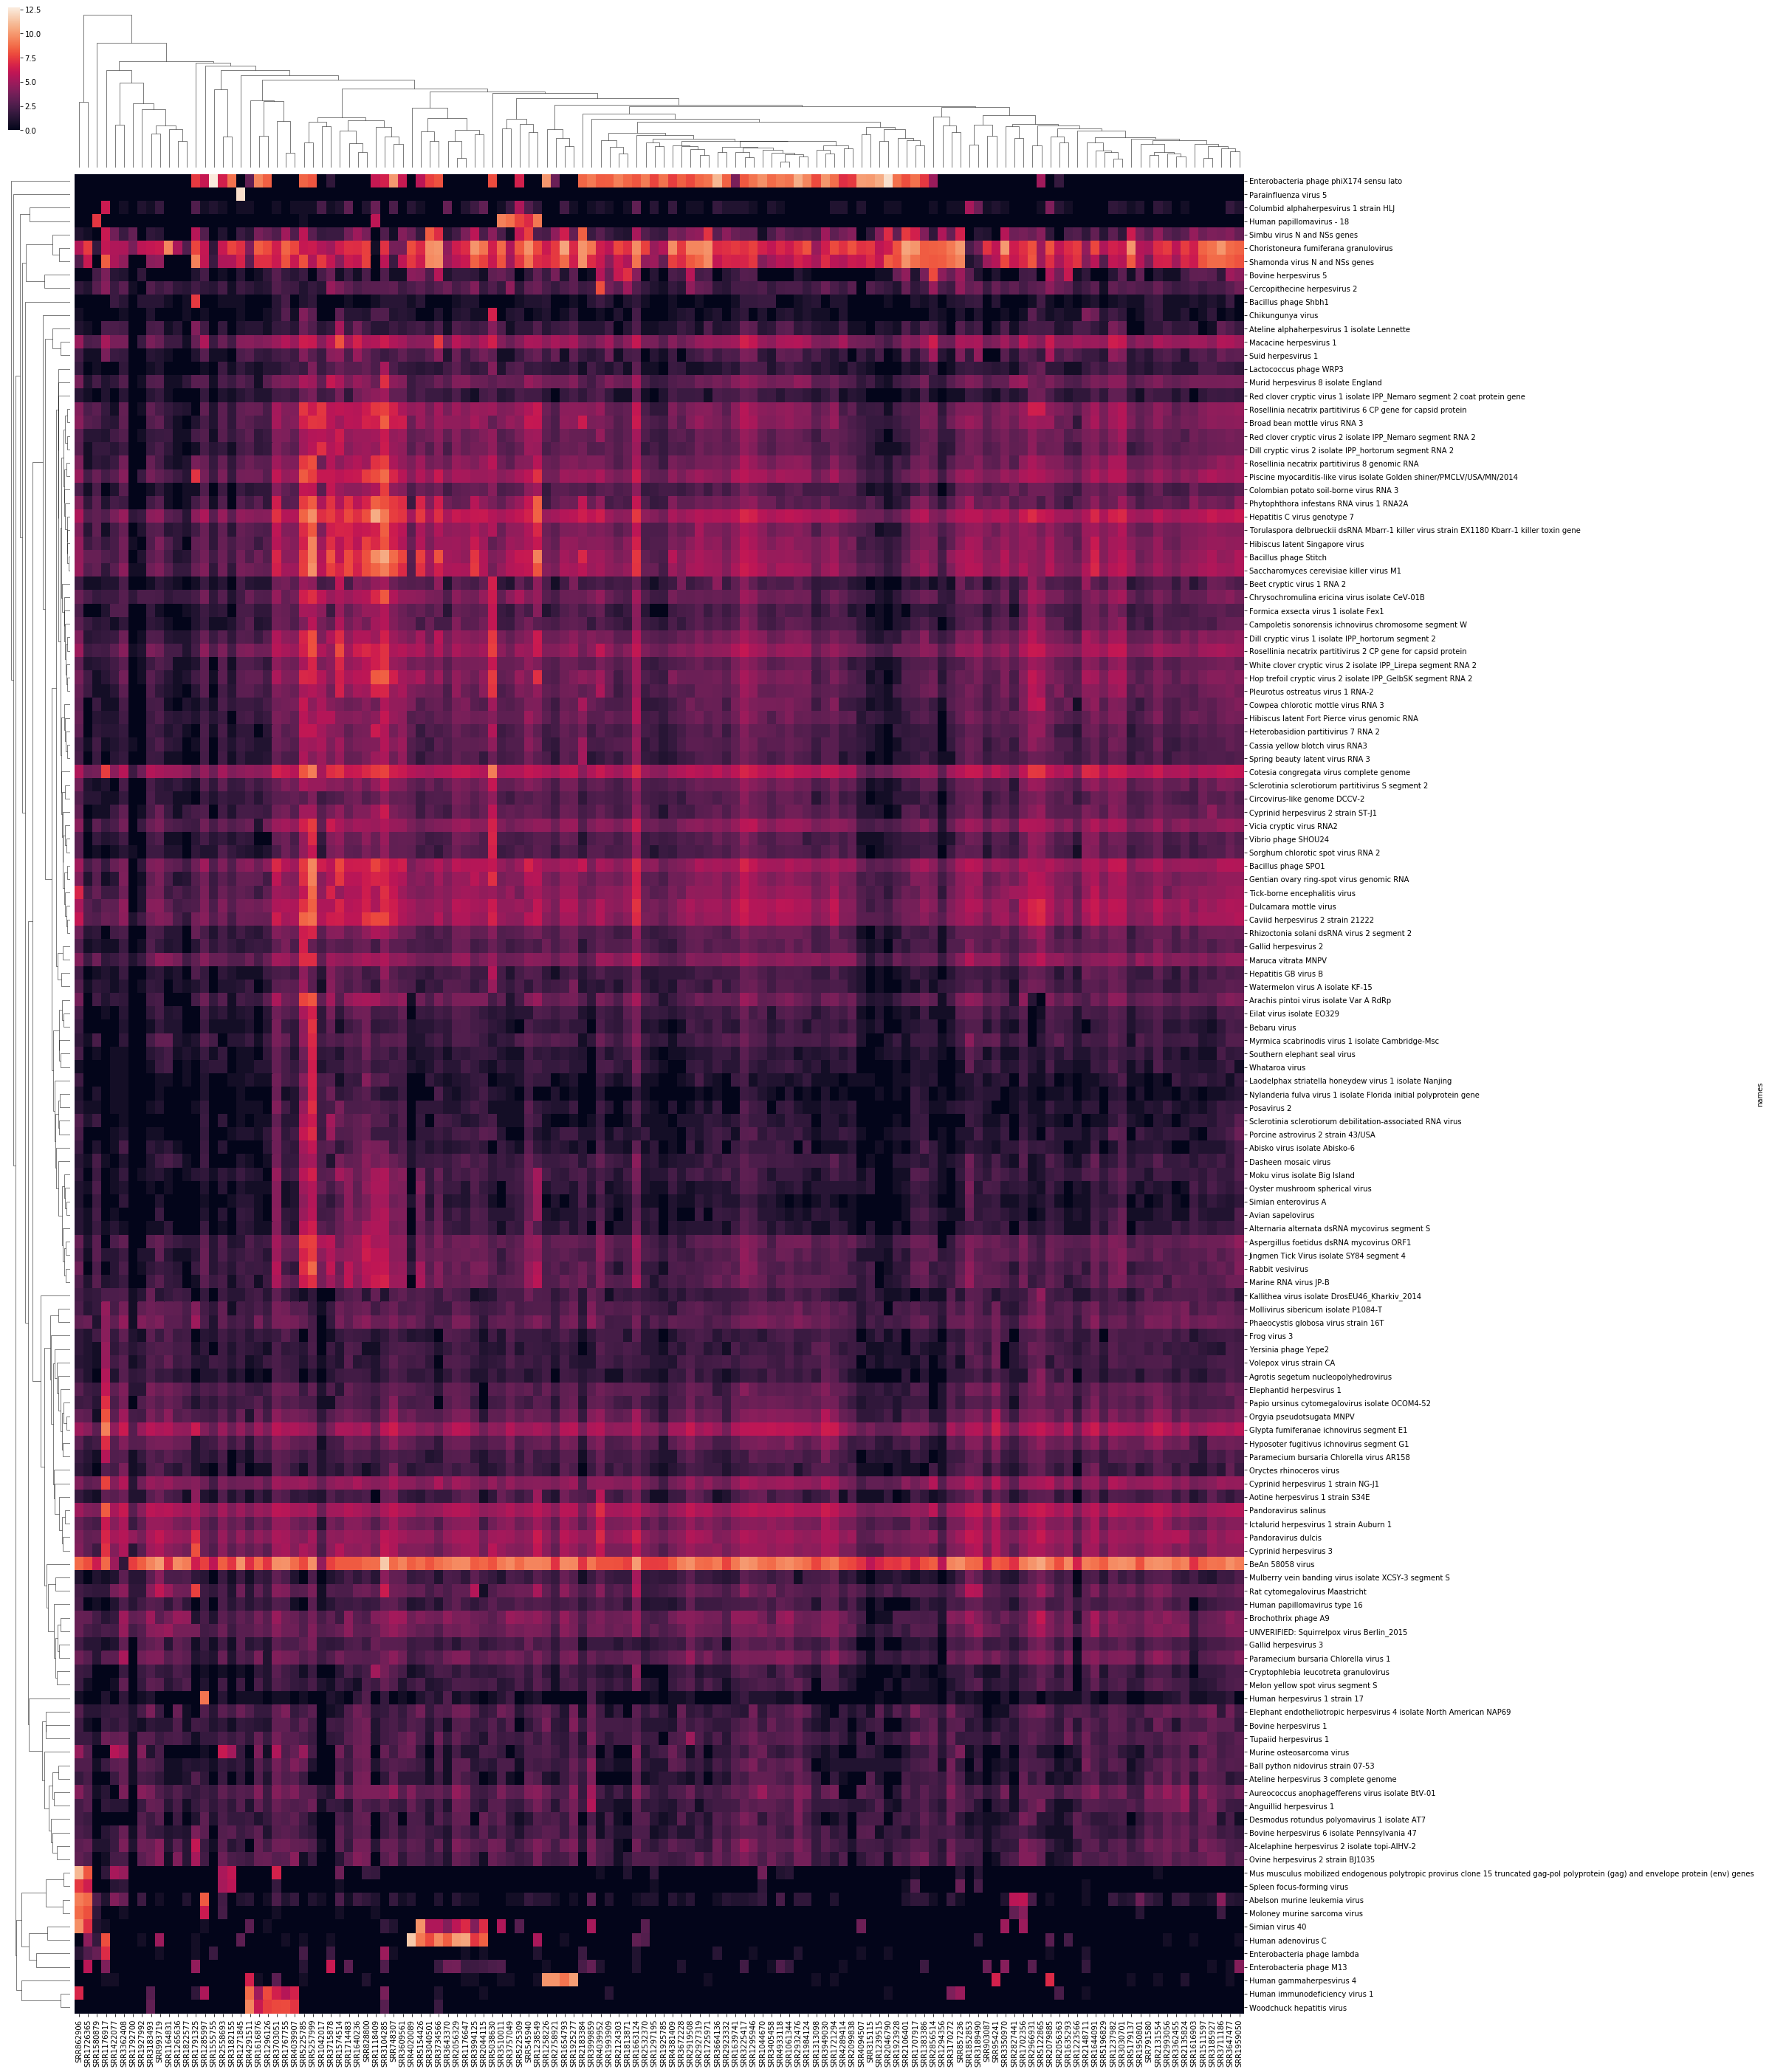

In [117]:
cedar_10000 = thresholdDataframe(cedar_df,1000.0)
print("Number of organism which is expressed more than 10K of the samples: {}".format(len(cedar_10000)))
sns.clustermap(np.log(cedar_10000+1),metric='correlation',figsize=(30,50))

In [118]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sci

In [119]:
def getLinkage(obs_mat):
    row_linkage = hierarchy.linkage(
        obs_mat, method='average')

    col_linkage = hierarchy.linkage(
        obs_mat.T, method='average')
    return row_linkage, col_linkage

In [120]:
row_linkage, col_linkage = getLinkage(cedar_10000)

In [124]:
row_linkage.shape, col_linkage.shape

((136, 4), (129, 4))

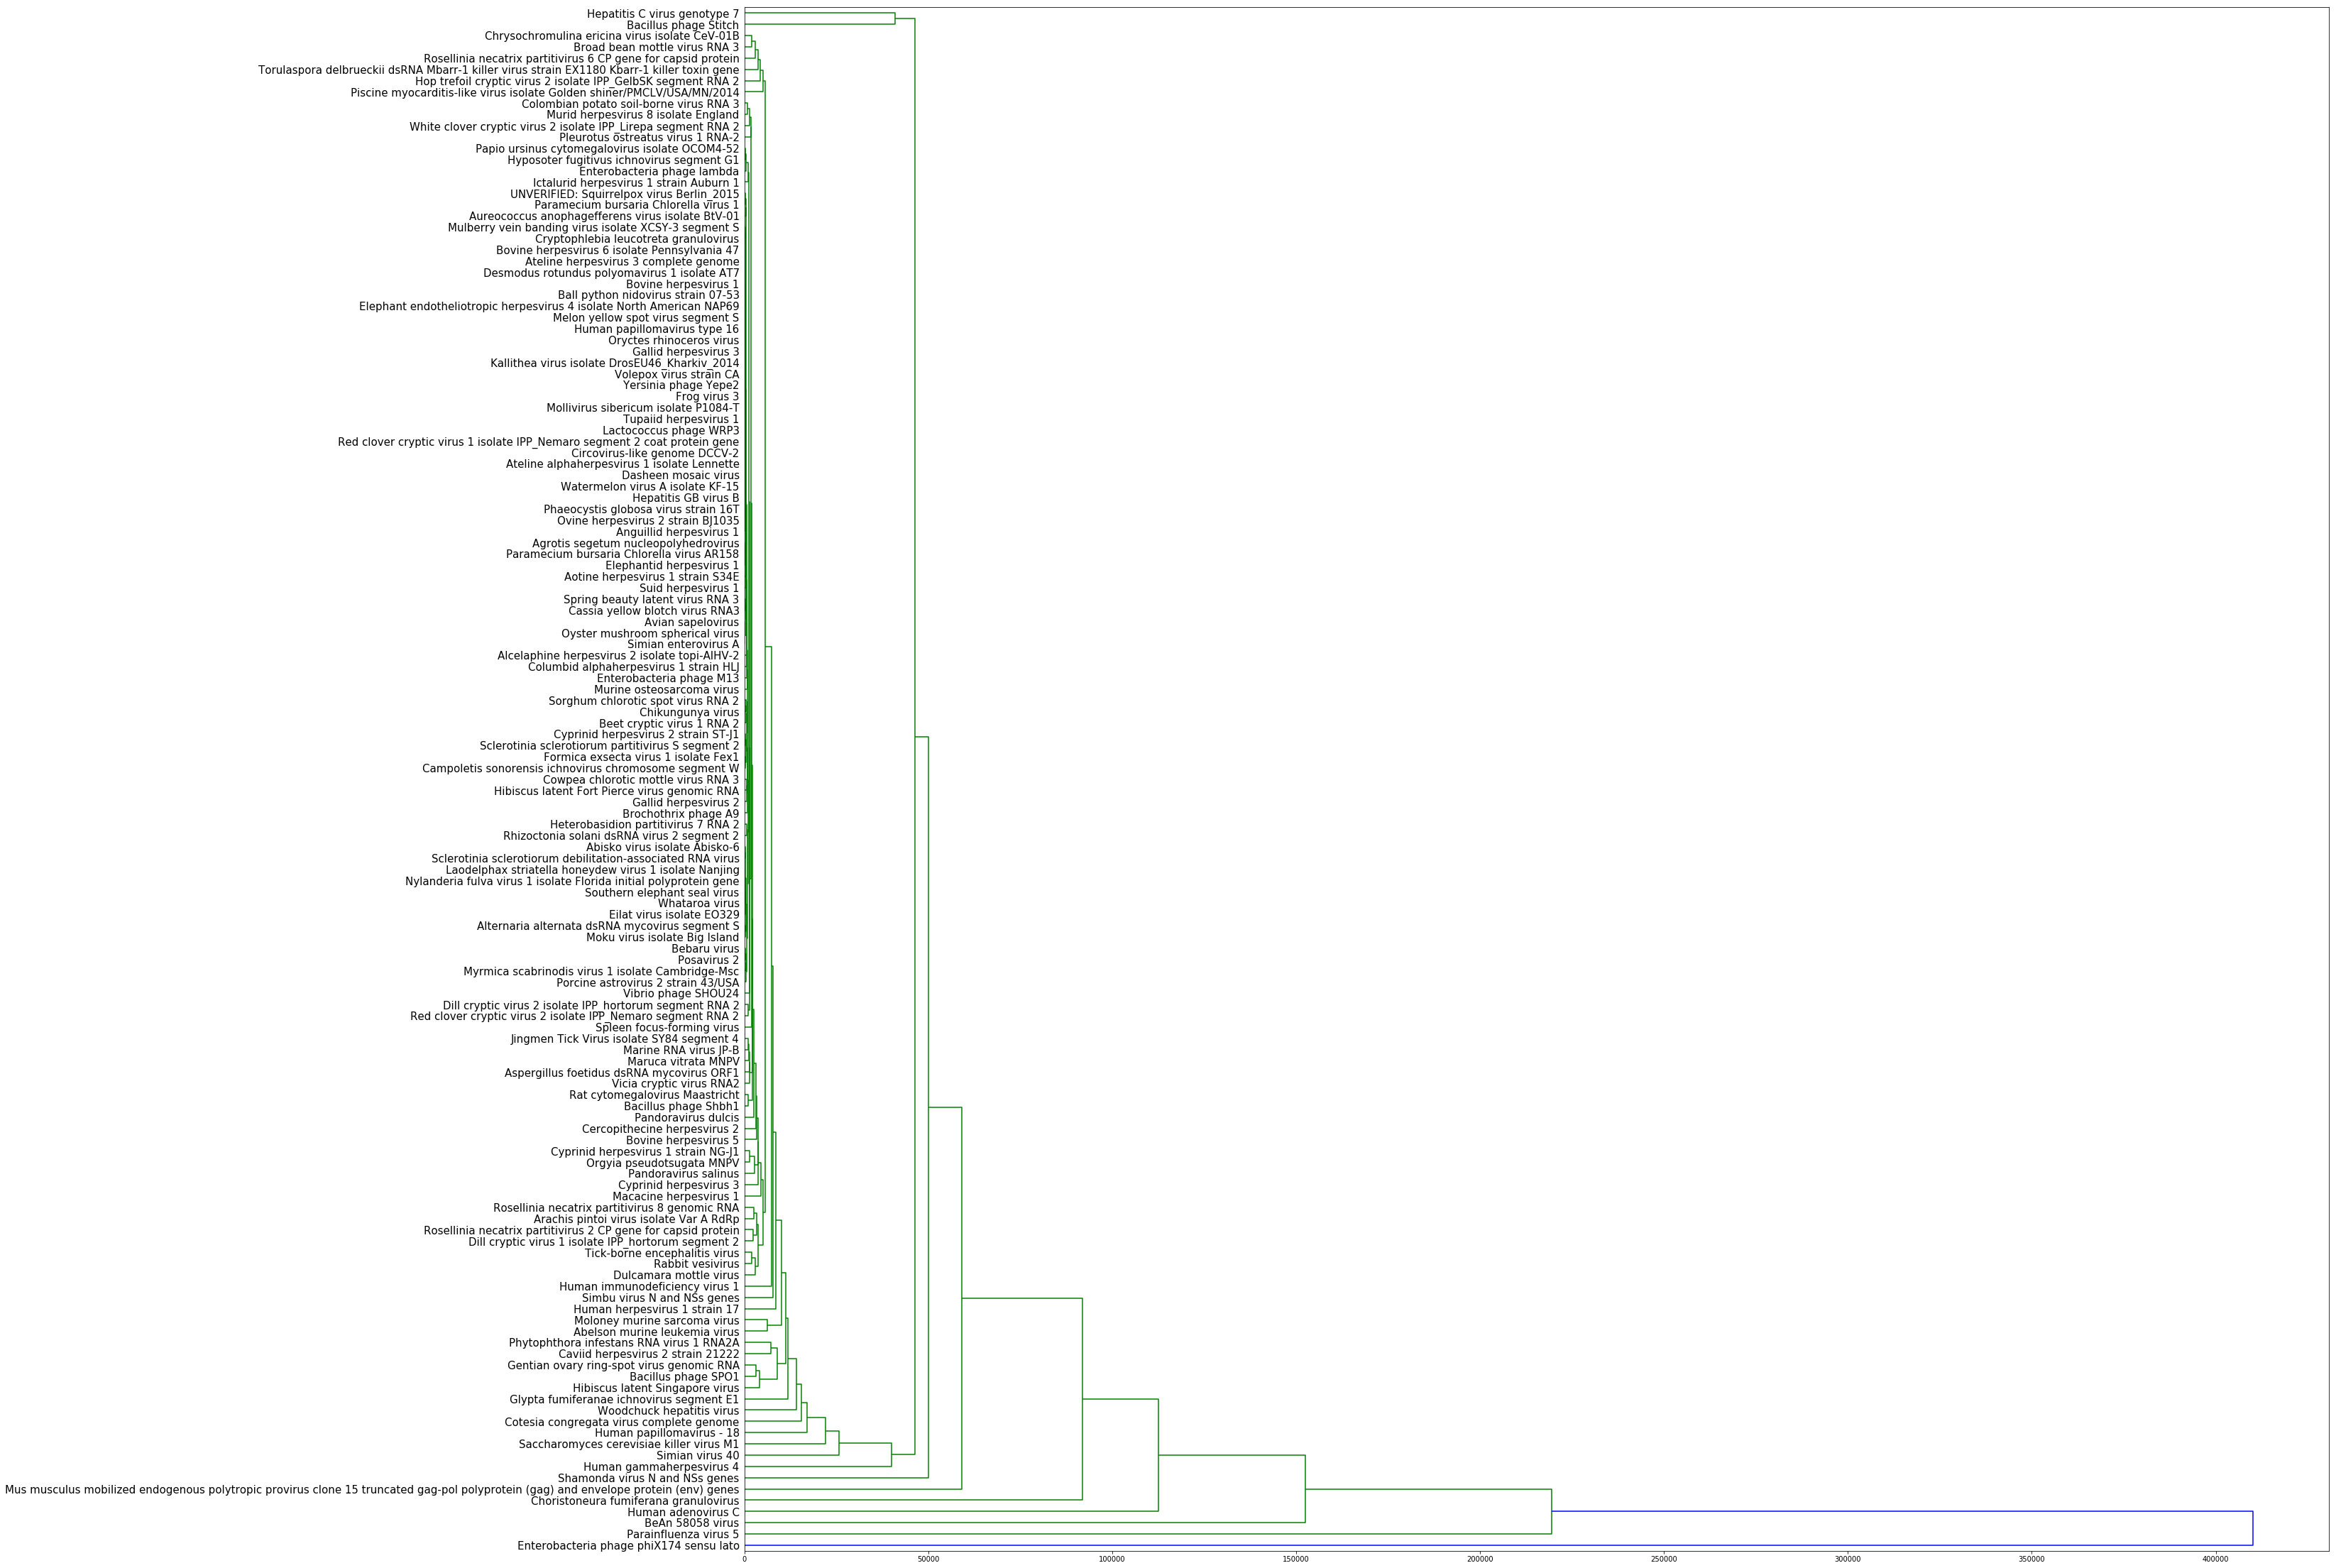

In [142]:
fig = plt.figure(figsize=(40, 40))
viras_d = hierarchy.dendrogram(row_linkage, labels=np.array(cedar_10000.index),
                               orientation="right",
                               show_leaf_counts=True,leaf_rotation=0,leaf_font_size=15)
plt.show()

### Using the table for clustering data
1. Clusteting of Bacteria
    - Color Bacteria by family
    - Color Bacteria by Genus
2. Clustering of Samples


In [152]:
cedar_transpose_NZ = cedar_df_lab_transpose.(axis=1)

In [190]:
hist_vals = (cedar_non_zero > 100.0).astype(int).sum(axis=1)

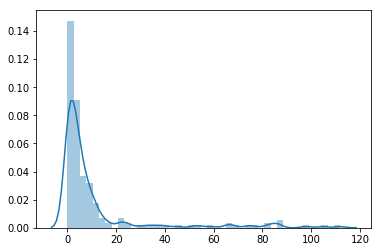

In [191]:
sns.distplot(hist_vals.values)

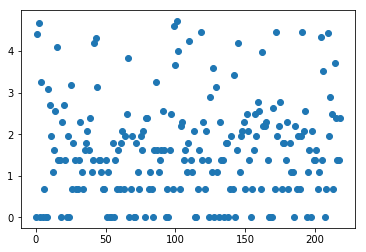

In [194]:
plt.scatter( range(0,len(hist_vals)),np.log(hist_vals.values+1))